Imports

In [1]:
%matplotlib inline

import dataLoader
import matplotlib.pyplot as plt
import torch
import CNN

# from config_plots import global_settings
# global_settings()
import warnings
warnings.filterwarnings("ignore")

Hyper parameters

In [2]:
# defining global variables
experimentName = "quicktest4"

from configParser import ConfigParser
params = ConfigParser(experimentName).read()
print(params)

experimentName = experimentName + "/single-trial"
import TrialStatistics
ts = TrialStatistics.TrialStatistics(experimentName)

{'image_path': './Fish_toy/images', 'training_count': 2, 'validation_count': 1, 'batchSize': 10, 'n_epochs': 3, 'numOfTrials': 3, 'kernels': [16, 32], 'kernelSize': 5, 'patience': 20, 'imageDimension': 28, 'n_channels': 1, 'useZCAWhitening': False}


Cuda support

In [3]:
# CUDA support 
if torch.cuda.is_available():
    torch.cuda.set_device(0) # 0
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("We are using cuda")

We are using cuda


Load images

In [4]:
import torchvision

# load images
dataset = dataLoader.FishDataset(params, True)
speciesList = dataset.getSpeciesList()
numberOfSpecies = len(speciesList)
print("Number of species = ", numberOfSpecies)

Number of images =  117
0 Abudefduf vaigiensis  has  4  images
1 Pardachirus pavoninus  has  5  images
2 Wetmorella albofasciata  has  5  images
3 Zebrasoma scopas  has  5  images
4 Acanthurus achilles  has  5  images
5 Anampses caeruleopunctatus  has  5  images
6 Wetmorella nigropinnata  has  5  images
7 Variola albimarginata  has  4  images
8 Upeneus moluccensis  has  5  images
9 Xiphocheilus typus  has  4  images
10 Acanthurus coeruleus  has  5  images
11 Acanthopagrus pacificus  has  3  images
12 Ablabys taenianotus  has  5  images
13 Acanthurus chirurgus  has  5  images
14 Amphiprion clarkii  has  5  images
15 Xenisthmus polyzonatus  has  5  images
16 Acanthemblemaria spinosa  has  4  images
17 Acanthemblemaria aspera  has  5  images
18 Acanthurus bahianus  has  4  images
19 Anampses geographicus  has  5  images
20 Amphiprion polymnus  has  5  images
21 abudefduf septemfasciatus  has  4  images
22 Lepidozygus tapeinosoma  has  5  images
23 Xanthichthys auromarginatus  has  5  imag

Create/Load model

In [5]:
import os

model = CNN.CNN(numberOfSpecies, params)

if os.path.exists(CNN.getModelFile(experimentName)):
    loss_list, accuracy_list, epochs, time_elapsed = CNN.loadModel(model, experimentName)
    test_loader = dataLoader.loadTestLoader(experimentName)
    print("Model {0} loaded!".format(experimentName))
else:
    train_loader, validation_loader, test_loader = dataLoader.getLoadersFromDataset(dataset, params, experimentName)
    loss_list, accuracy_list, epochs, time_elapsed = CNN.trainModel(train_loader, validation_loader, params, model, experimentName)

N/A% (0 of 3) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Training started...


100% (3 of 3) |##########################| Elapsed Time: 0:00:11 Time:  0:00:11


Plot

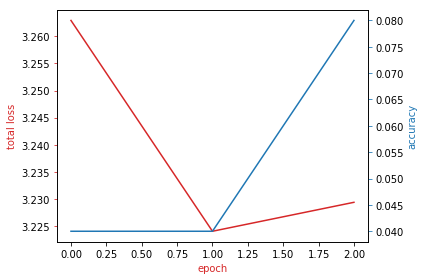

In [6]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('total loss', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

Create confusion matrix

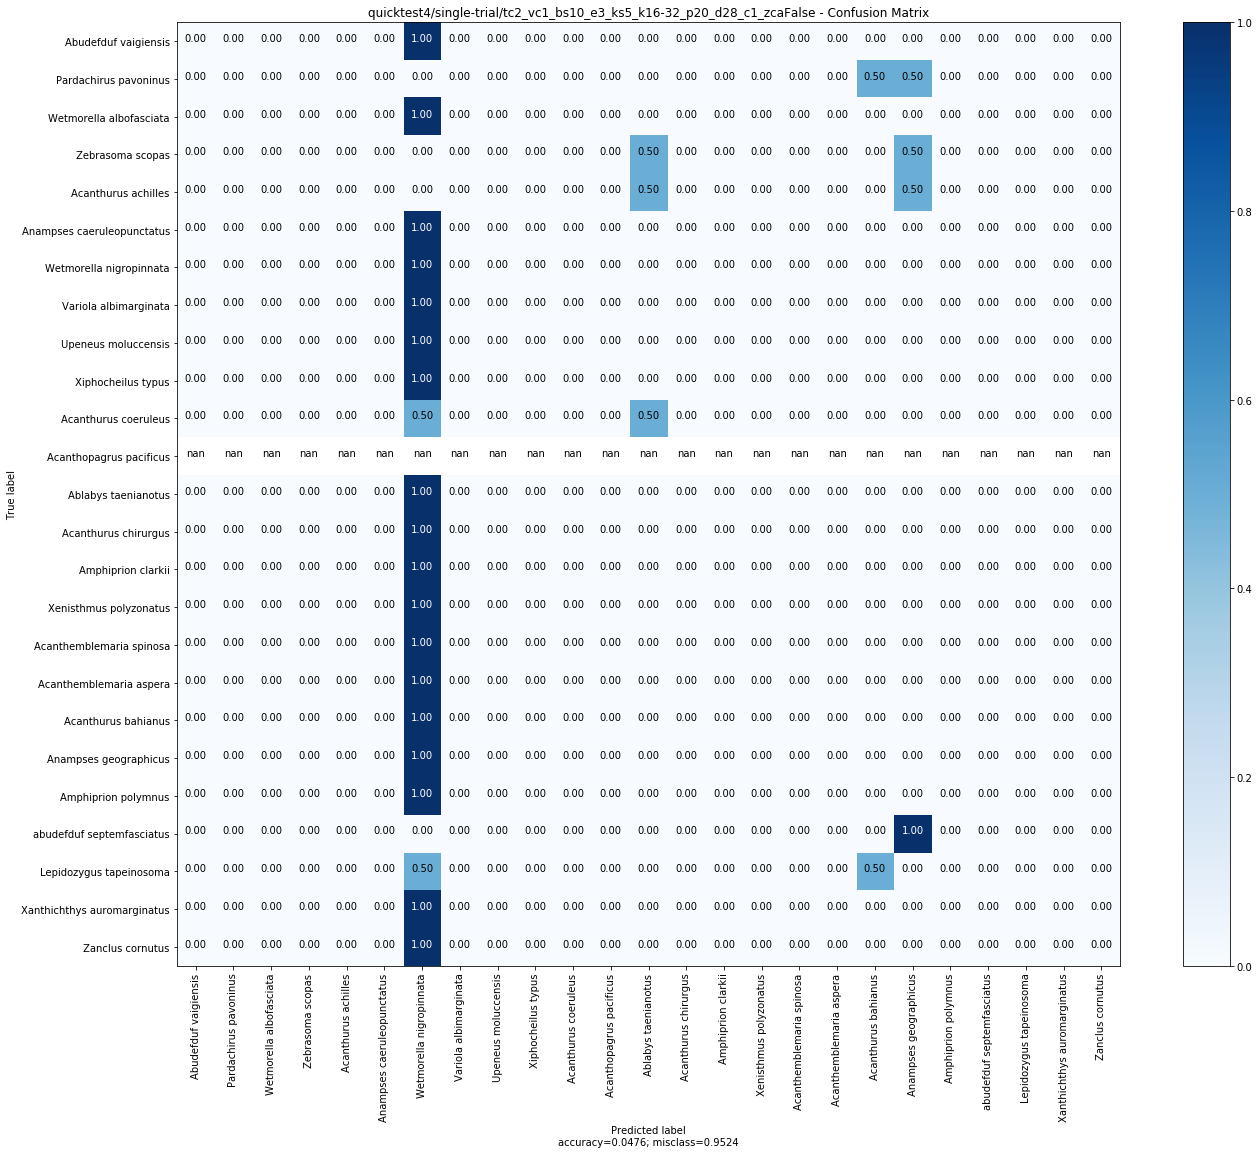

In [7]:
predlist, lbllist = CNN.getLoaderPredictions(test_loader, model)
ts.addTrialPredictions(params, predlist, lbllist, numberOfSpecies)
conf_mat = ts.printTrialConfusionMatrix(params, speciesList, True)

Precision/Recall/Fscore

In [8]:
ts.addTrial(params,
            {'loss': CNN.getCrossEntropyFromLoader(test_loader, model),
             'accuracy': CNN.getAccuracyFromLoader(test_loader, model),
             'time': time_elapsed,
             'epochs': epochs
            })

ts.showStatistics()
ts.showStatistics(False)
ts.saveStatistics()
ts.saveStatistics(False)

Aggregated statistics


Raw statistics


,image_path,training_count,validation_count,batchSize,n_epochs,numOfTrials,kernels,kernelSize,patience,imageDimension,n_channels,useZCAWhitening,loss,accuracy,time,epochs,hash
0,./Fish_toy/images,2,1,10,3,3,16 32,5,20,28,1,False,3.216027,0.047619,11.671449,3,-3718837947567101547


Plot parameters of first layer

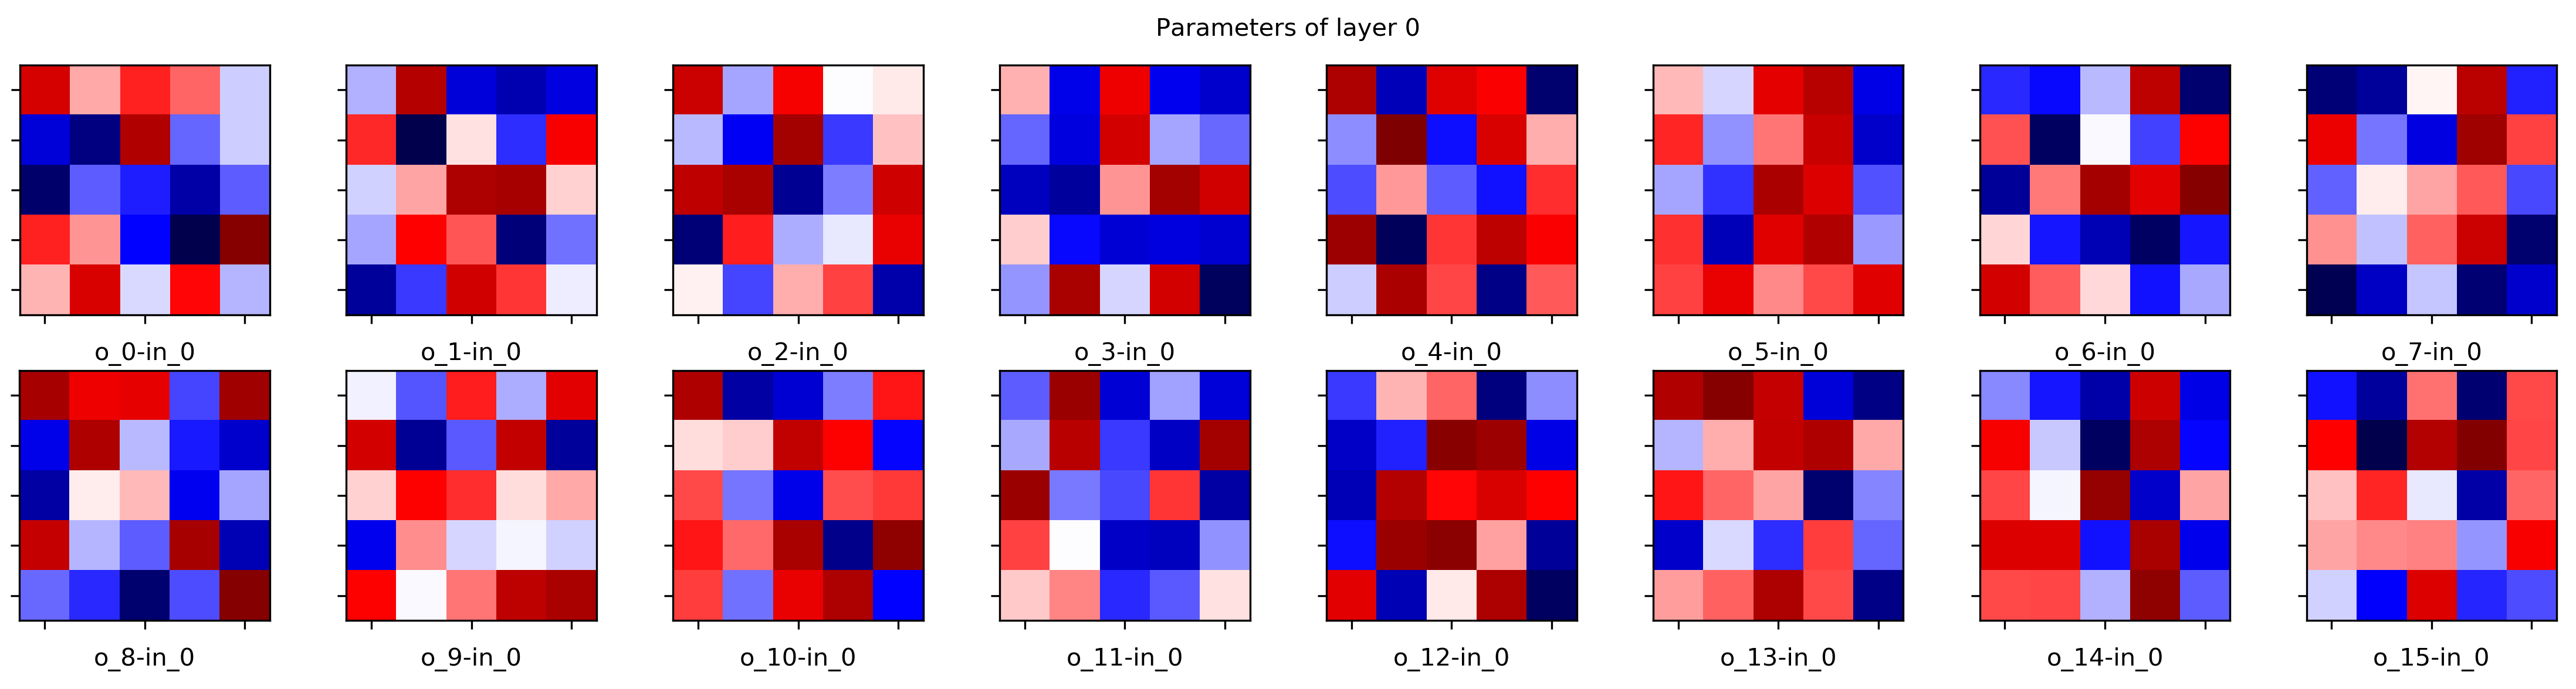

In [9]:
import PlotNetwork
PlotNetwork.plot_channels(model, 0, experimentName)

Plot parameters of second layer

In [10]:
PlotNetwork.plot_channels(model, 1, experimentName)

Plot activations

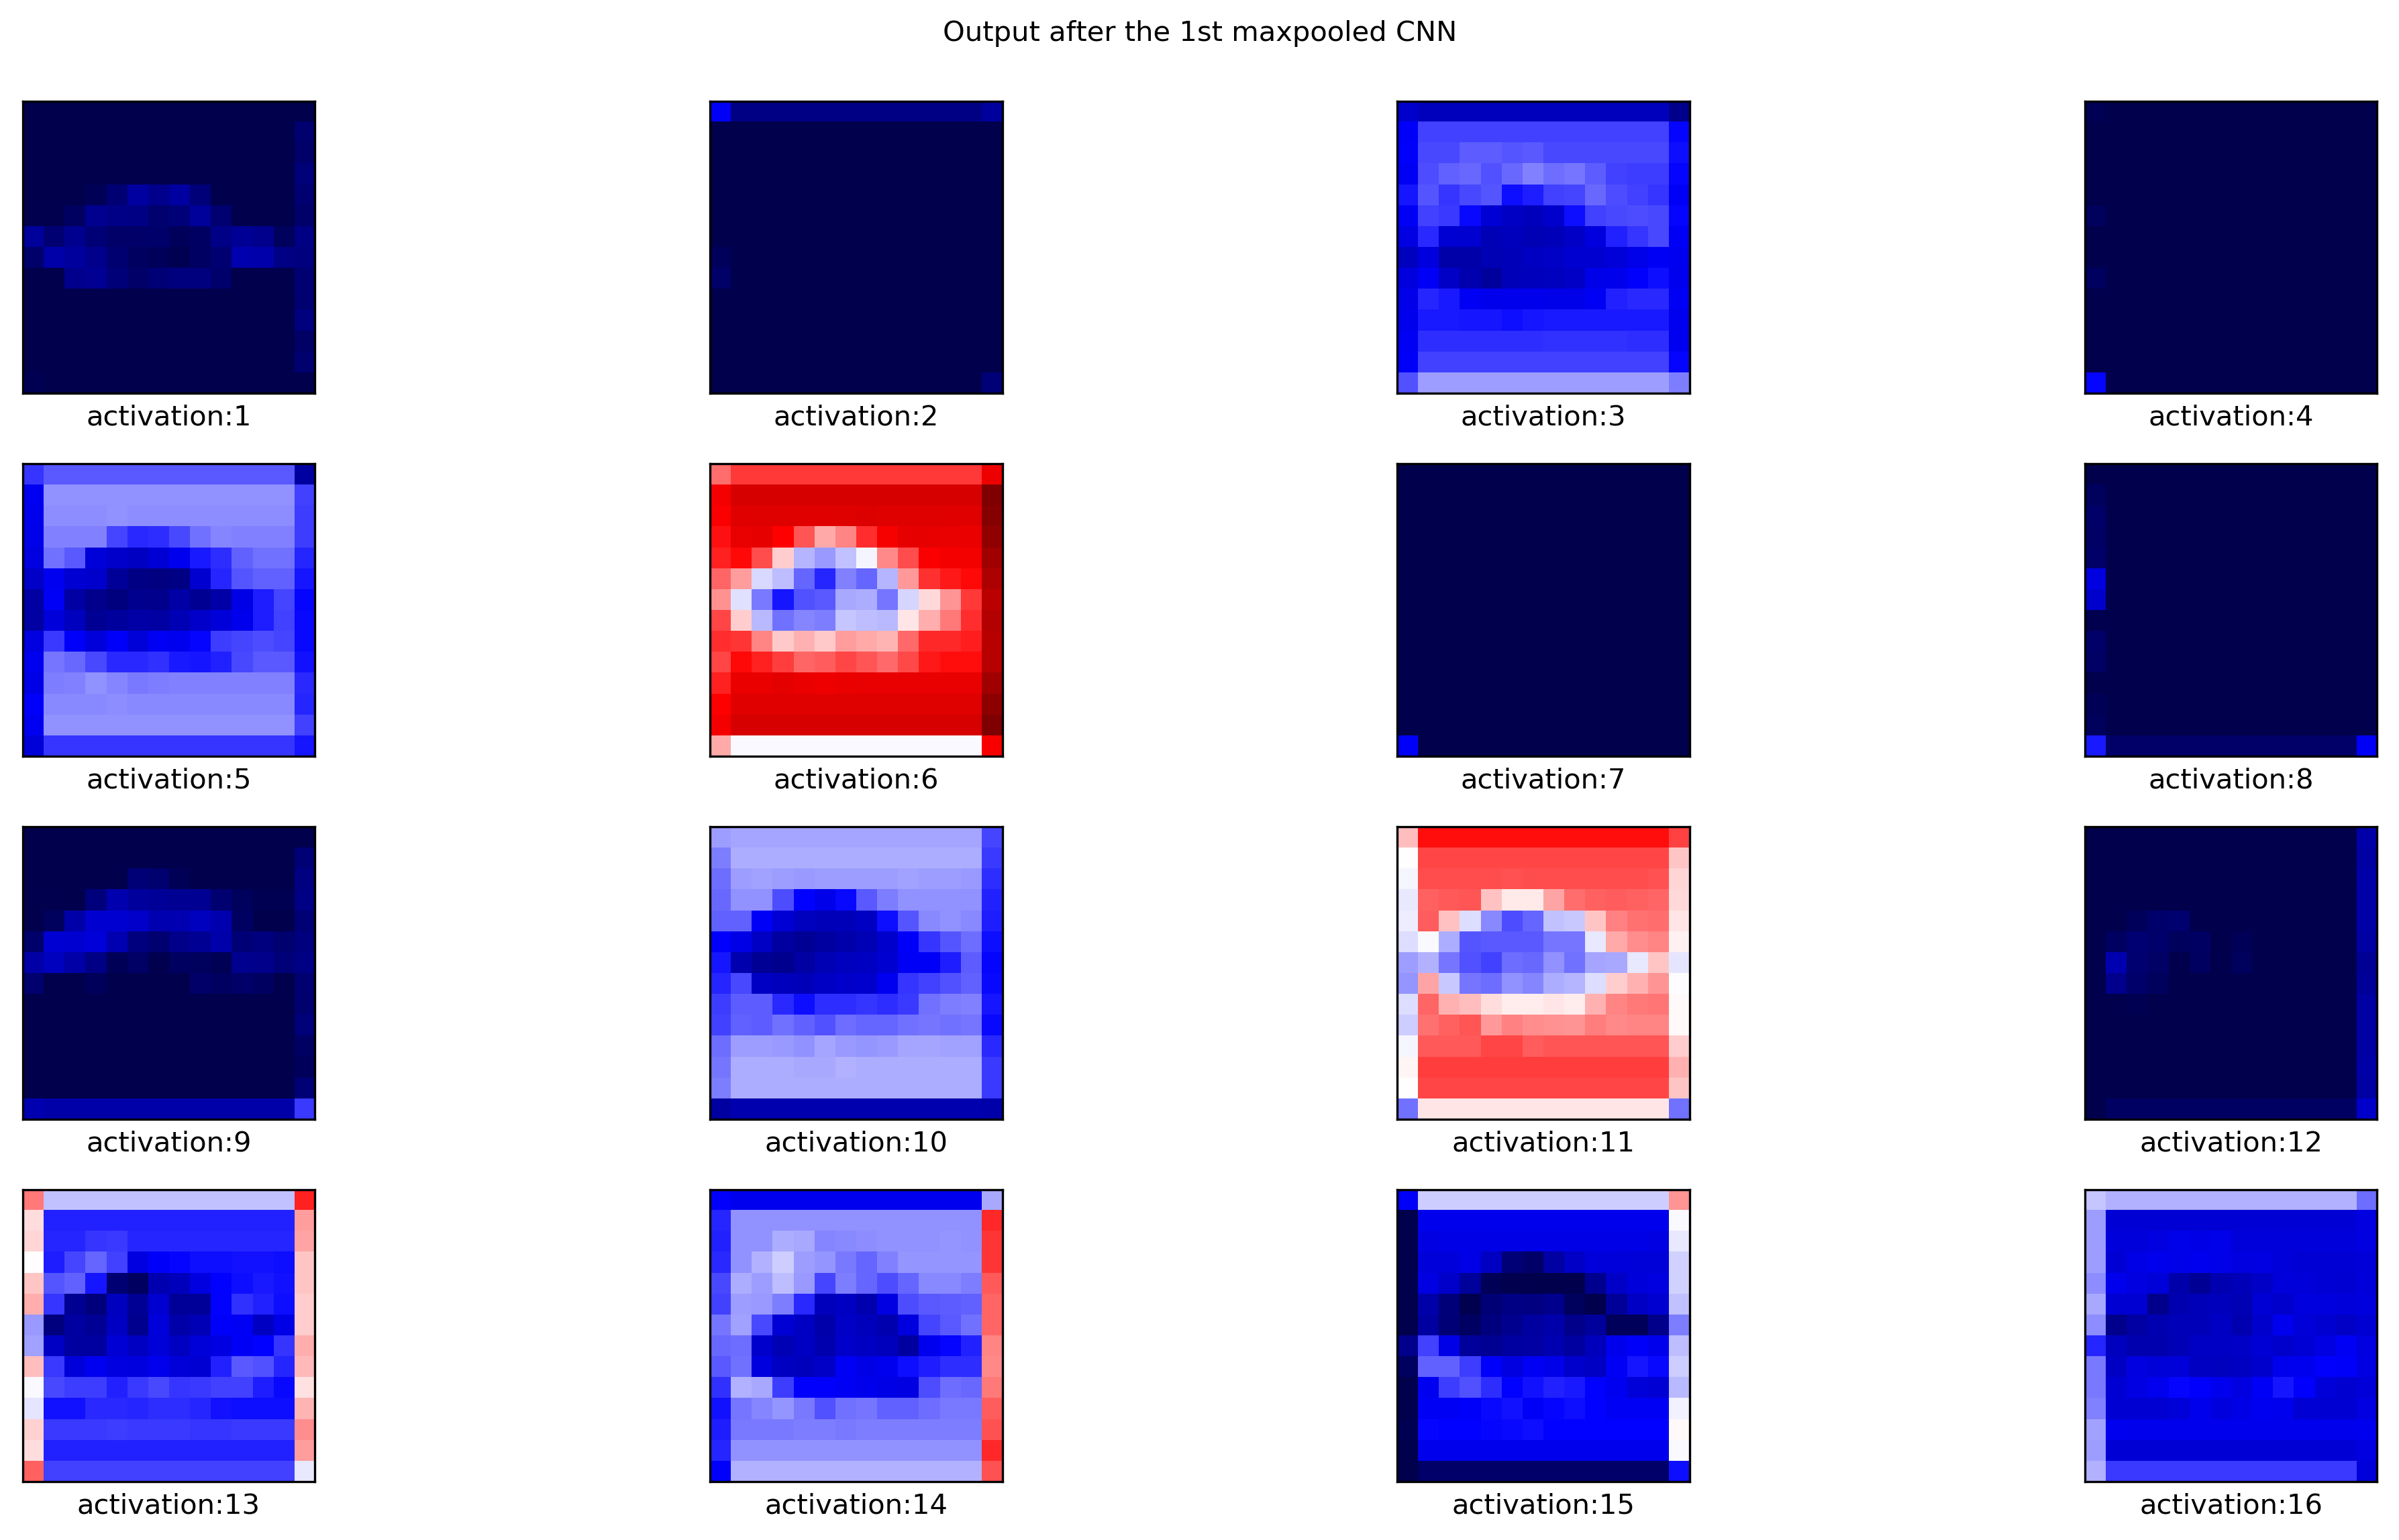

In [11]:
# Which example you want to plot for?
exampleId = 0

imageDimension = params["imageDimension"]
n_channels = params["n_channels"]
inpt, cnn_outputs, relu_outputs, maxpool_outputs, flattened_outputs, out = model.activations(dataset[exampleId]['image'].view(1, n_channels, imageDimension, imageDimension))
# PlotNetwork.plot_activations(cnn_outputs[0], experimentName, "Output after the 1st CNN", 4)
PlotNetwork.plot_activations(maxpool_outputs[0], experimentName, "Output after the 1st maxpooled CNN", 4)

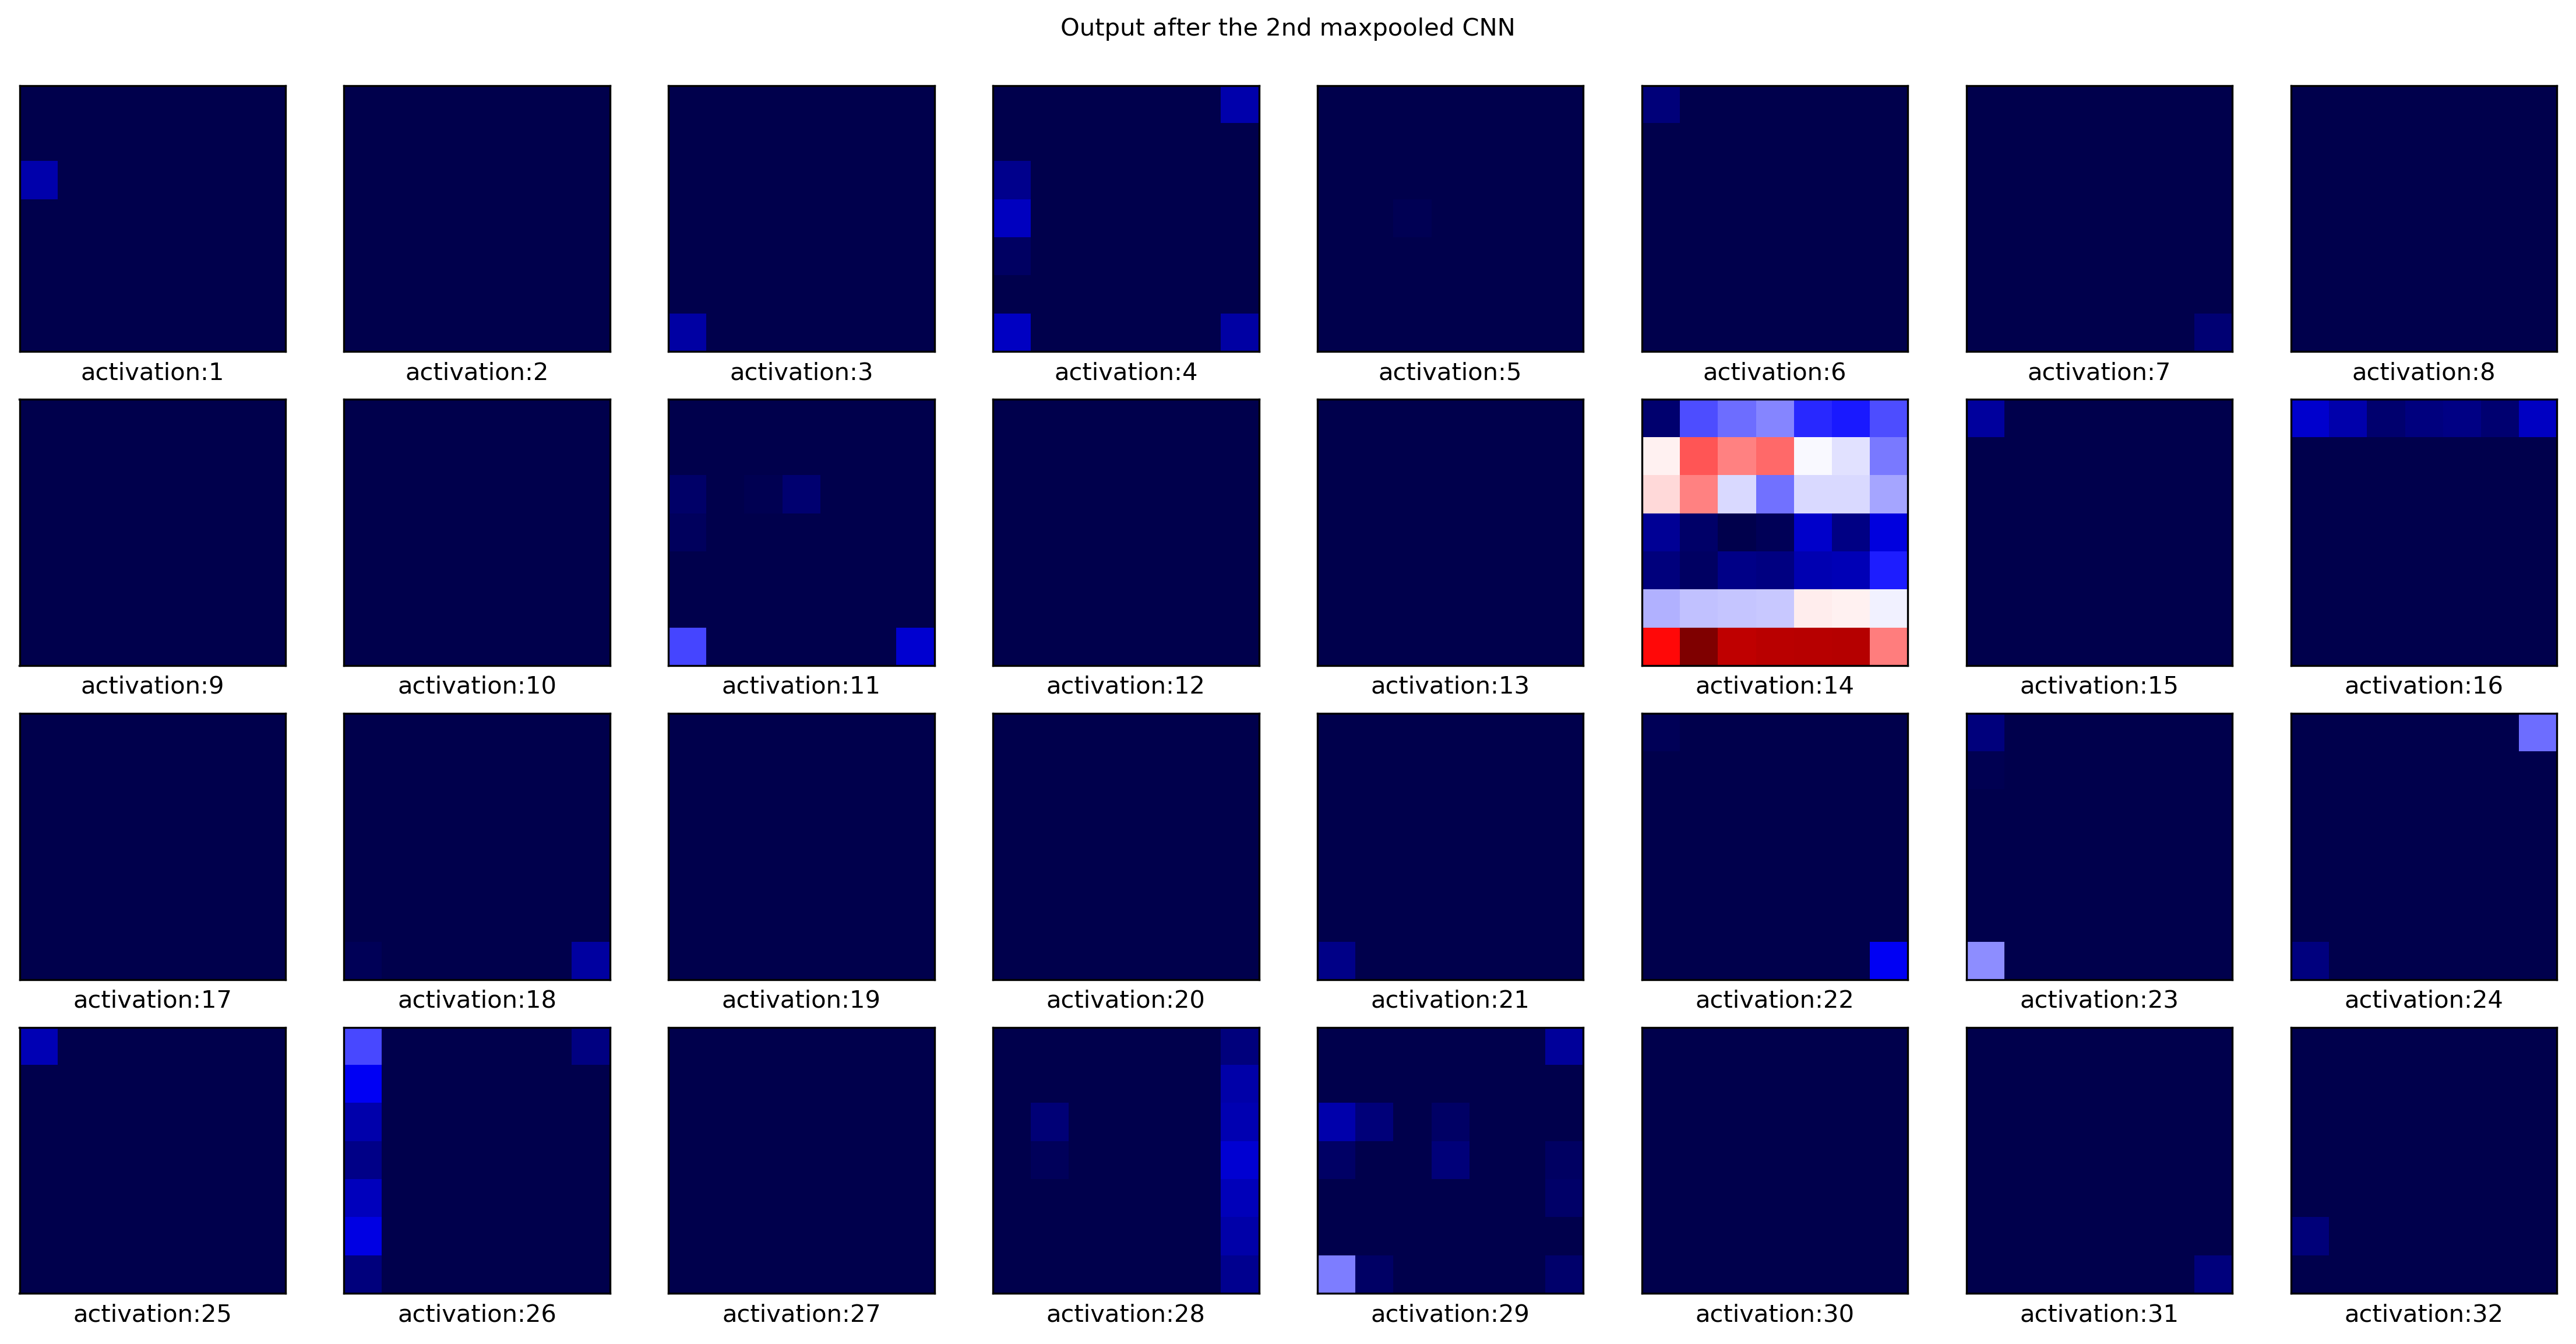

In [12]:
# PlotNetwork.plot_activations(cnn_outputs[1], experimentName, "Output after the 2nd CNN", 4)
PlotNetwork.plot_activations(maxpool_outputs[1], experimentName, "Output after the 2nd maxpooled CNN", 4)

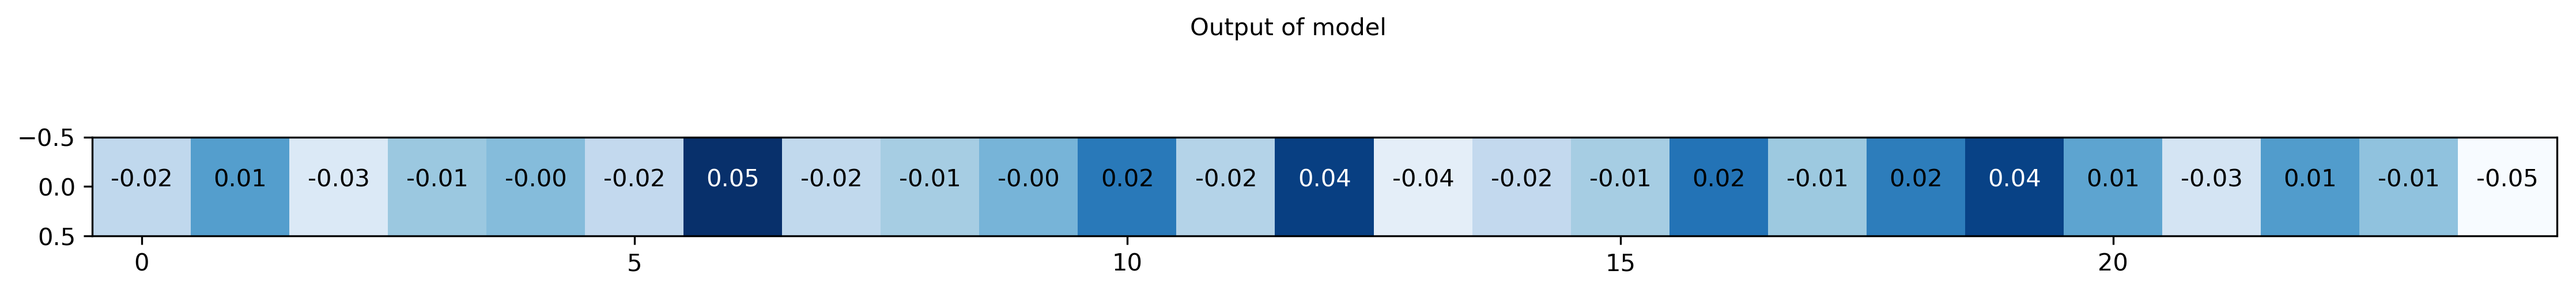

In [13]:
PlotNetwork.plot_activations(out, experimentName, "Output of model", 25)

Least confused classes

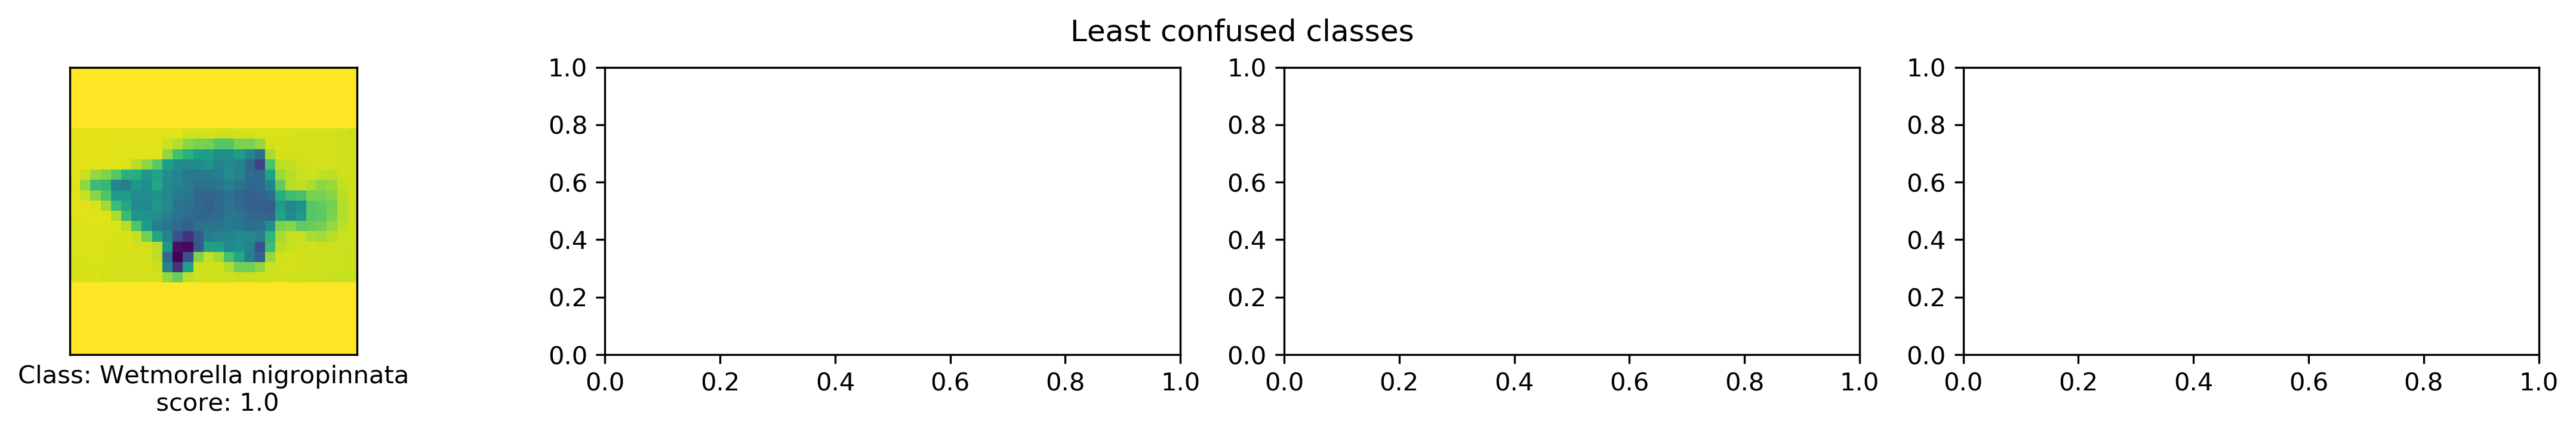

In [14]:
import numpy as np
import math

# From the confusion matrix, find the diagonal entries that have high value.
SuccessThreshold = 0.8

cm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
diagIndices = di = np.diag_indices(cm.shape[0])
conf_mat_diagValues = cm[diagIndices]

goodMatches = [i for i,v in enumerate(conf_mat_diagValues) if v >= SuccessThreshold]
goodMatches_count = len(goodMatches)

# Plot
number_per_row = 4
n_rows = math.ceil(goodMatches_count/number_per_row)
fig, axes = plt.subplots(n_rows, number_per_row, figsize=(15, 2.5*n_rows), dpi= 300)
out_index = 0
in_index = 0
for i, ax in enumerate(axes.flat):
    if i < goodMatches_count:
        index = goodMatches[i]
        speciesName = dataset.getSpeciesOfIndex(index)
        ax.set_xlabel("Class: {0}\n score: {1}".format(speciesName, conf_mat_diagValues[index]))

        # Plot the image.
        speciesExamples = dataset.getSpeciesIndices(speciesName)
        speciesExample = dataset[speciesExamples[0]]['image'].squeeze()

        if n_channels != 1:
            speciesExample = speciesExample.permute(1, 2, 0)
        ax.imshow(speciesExample.cpu().detach().numpy())
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        break
        
fig.suptitle("Least confused classes")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()
fig.savefig(experimentName+"/LestConfusedClasses.png")
    
    

Most confused classes

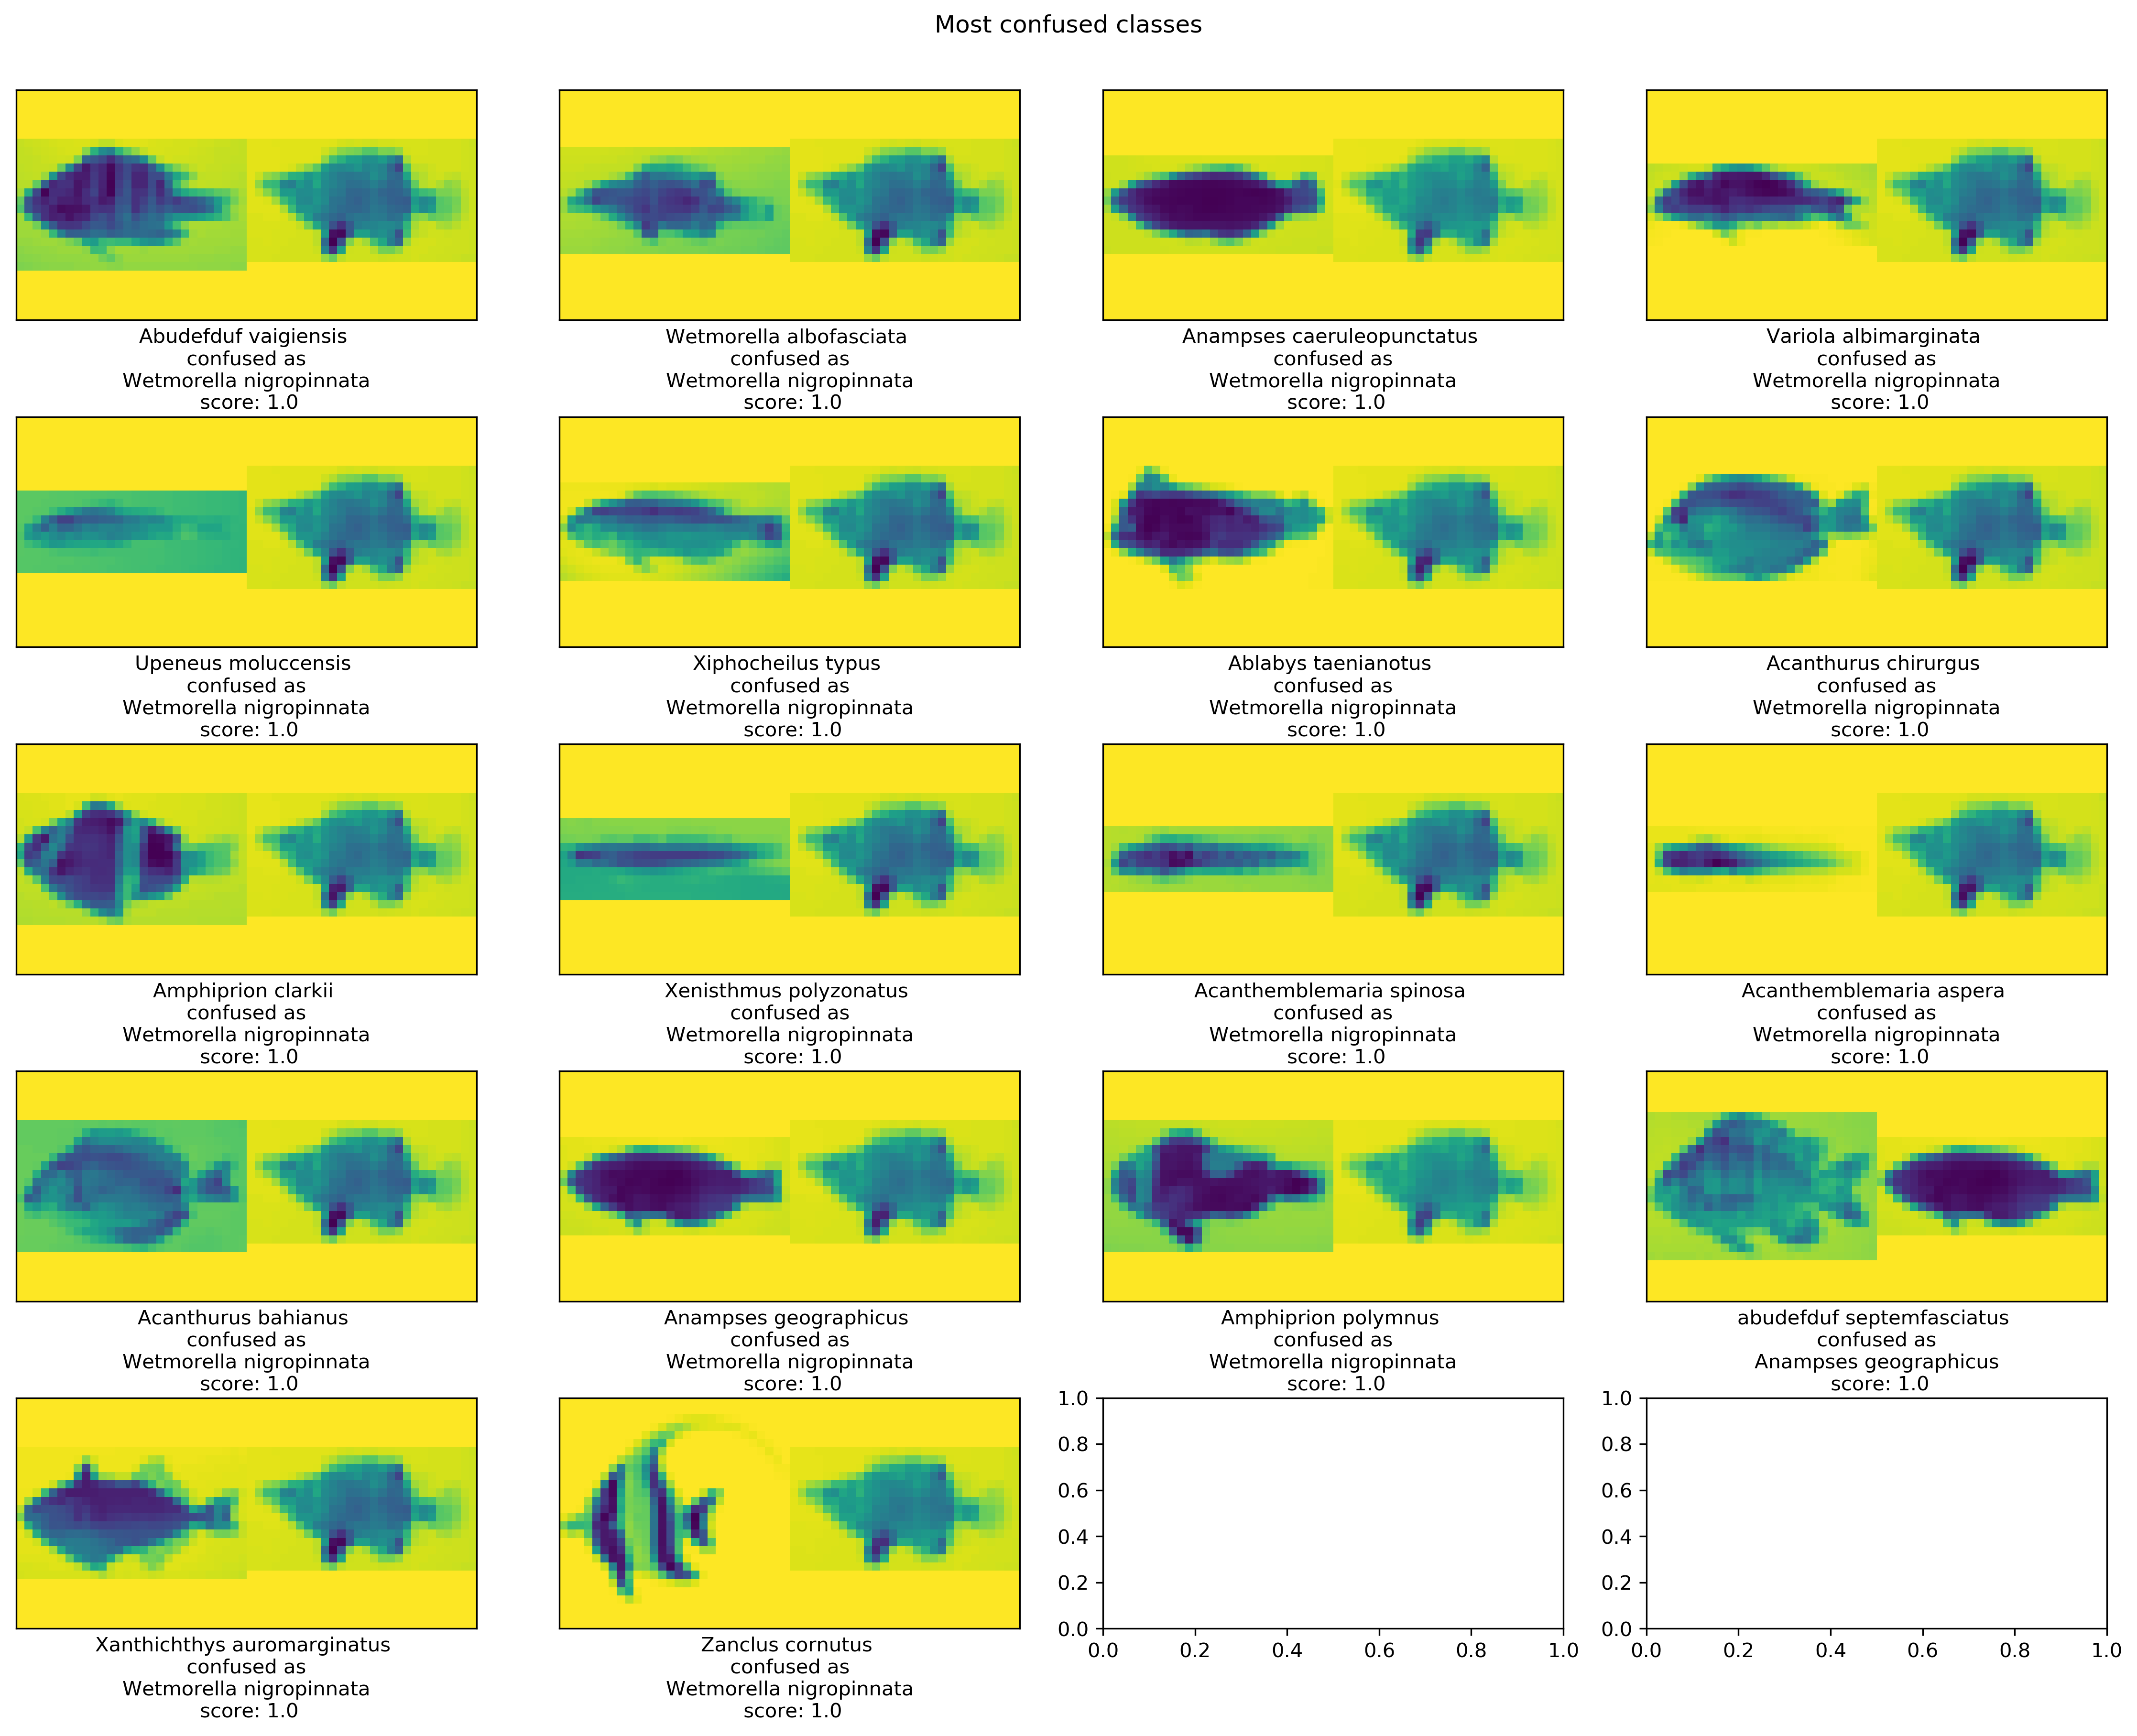

In [15]:
# From the confusion matrix, find the diagonal entries that have high value.
ConfusionThreshold = 0.8

cm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
diagIndices = di = np.diag_indices(cm.shape[0])

goodMatches = [(x, y) for (x, y), v in np.ndenumerate(cm) if v >= ConfusionThreshold and x != y]
goodMatches_count = len(goodMatches)

number_per_row = 4
n_rows = math.ceil(goodMatches_count/number_per_row)
fig, axes = plt.subplots(n_rows, number_per_row, figsize=(15, 2.5*n_rows), dpi= 300)
out_index = 0
in_index = 0
for i, ax in enumerate(axes.flat):
    if i < goodMatches_count:
        (x, y) = goodMatches[i]
        speciesNameConfused = dataset.getSpeciesOfIndex(x)
        speciesNameConfusedAs = dataset.getSpeciesOfIndex(y)
        ax.set_xlabel("{0} \n confused as \n{1}\n score: {2}".format(speciesNameConfused, speciesNameConfusedAs, cm[x][y]))

        # Plot the image.
        confusedSpeciesExamples = dataset.getSpeciesIndices(speciesNameConfused)
        confusedSpeciesExample = dataset[confusedSpeciesExamples[0]]['image'].squeeze()
        confusedAsSpeciesExamples = dataset.getSpeciesIndices(speciesNameConfusedAs)
        confusedAsSpeciesExample = dataset[confusedAsSpeciesExamples[0]]['image'].squeeze()

        channel = 2 if n_channels != 1 else 1
        stitchedImage = torch.cat((confusedSpeciesExample, confusedAsSpeciesExample), channel)
        
        if n_channels != 1:
            stitchedImage = stitchedImage.permute(1, 2, 0)
        ax.imshow(stitchedImage.cpu().detach().numpy())
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        break
        
fig.suptitle("Most confused classes")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()
fig.savefig(experimentName+"/MostConfusedClasses.png")